## 🎯 Challenge
Predict Waste Production for its Reduction


## 👥 Authors

* Claire Benard
* Diego Arenas
* Natalie Muenter
* Tom Constant
* Tom Wagstaff


## 💻 Development


### 🦺 Set up

In [1]:
import pandas as pd
from datetime import datetime
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline



Bad key "text.kerning_factor" on line 4 in
/Users/nmm/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### 🧼 Data import and cleaning

Let's import the **clean data**. Details of how the data was cleaned are available in the appendix but here is a summary of the issues we identified and the decisions we made:

1) The dataset was supposed to have `Load.ID` has a primary key, it wasn't the case so we removed duplicates and selected the first row of groups that shared a `Load.ID` (44 rows)

2) We removed rows with `Load.Weight` missing. 99.6% of them were in `SWEEPING` which we removed from the analysis anyway 

3) The time series is incomplete for some load types. We kept data from **2005** 

4) `Load.Type` categories don't seem mutually exclusive.

This could be because over time, recycling streams got split into different categories or the data collection process changed over time. We kept the categories making up most of the waste, namely: **Brush, Bulk, Dead animal, Garbage collections, Litter, Mixed Litter, Recycled Metal, Recycling - single stream, Tires and Yard Trimming.**

5) There were some data errors and extreme values that needed to be removed from the analysis. We used an **isolation forest** to identify outliers

6) We grouped the data by day, load type and route number

7) Merged in the population data

In [2]:
data = pd.read_csv('../data/clean_data_CB.csv')
data.head(5)

,date,year,month,wday,Load.Type,Route.Type,Dropoff.Site,Route.Number,outlier,total_pop,annualised_growth,gdp,nb_loads,daily_weight
0,03/01/2005,2005,1,Mon,BRUSH,BRUSH,HORNSBY BEND,BR05,outlier,700407,1.20%,69658.104,3,17400.0
1,03/01/2005,2005,1,Mon,BRUSH,BRUSH,HORNSBY BEND,BRPN01,outlier,700407,1.20%,69658.104,1,3140.0
2,03/01/2005,2005,1,Mon,BRUSH,BRUSH,HORNSBY BEND,BRPS01,outlier,700407,1.20%,69658.104,1,5640.0
3,03/01/2005,2005,1,Mon,BULK,BULK,STEINER LANDFILL,BU27,normal,700407,1.20%,69658.104,1,4620.0
4,03/01/2005,2005,1,Mon,BULK,BULK,TDS LANDFILL,BU27,outlier,700407,1.20%,69658.104,6,69380.0


In [3]:
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))

In [4]:
data['waste_by_person'] = data.daily_weight/data.total_pop

### 🧙‍♀️ Modeling

We focus on GARBAGE COLLECTION and RECYCLING - SINGLE STREAM and we create a prophet model for each type

#### Garbage model

In [5]:
filtered_data = data[(((data['Load.Type'] == "GARBAGE COLLECTIONS") & (data['Route.Type'] == "GARBAGE COLLECTION")) |
                      ((data['Load.Type'] == "RECYCLING - SINGLE STREAM") & (data['Route.Type'] == "RECYCLING - SINGLE STREAM"))) &
                      (data['outlier'] == "normal")]

In [6]:
df_gc = filtered_data[filtered_data['Load.Type'] == "GARBAGE COLLECTIONS"].groupby(['date'])['waste_by_person'].sum().reset_index()

df_gc.columns = ['ds', 'y']
df_gc = df_gc[df_gc.y > 0.5] 
df_gc_train = df_gc[df_gc.ds < '2020-01-01']
df_gc_test = df_gc[df_gc.ds >= '2020-01-01']

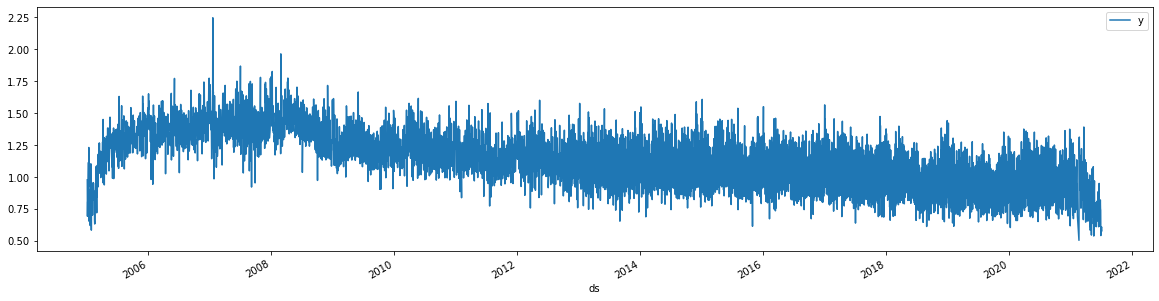

In [7]:
df_gc.plot(x ='ds', y='y', kind = 'line',figsize=(20, 5))

Fiting a prophet model just for Garbage Collection load type

In [18]:
m_gc = Prophet()
m_gc.fit(df_gc_train)
future_gc = m_gc.make_future_dataframe(periods=365*2)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
forecast_gc = m_gc.predict(future_gc)
forecast_gc[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail();

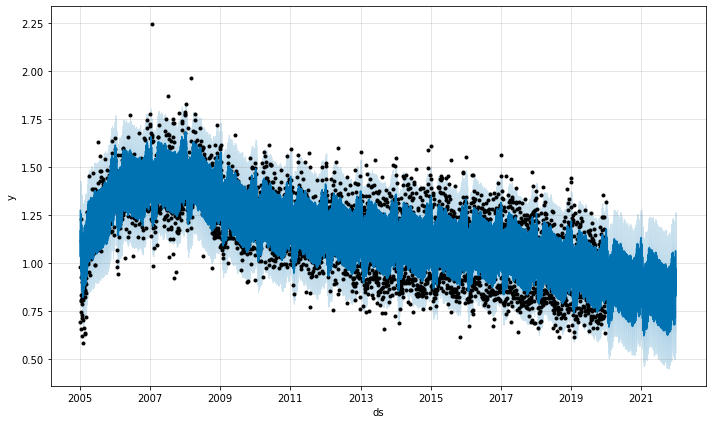

In [35]:
fig1_gc = m_gc.plot(forecast_gc)

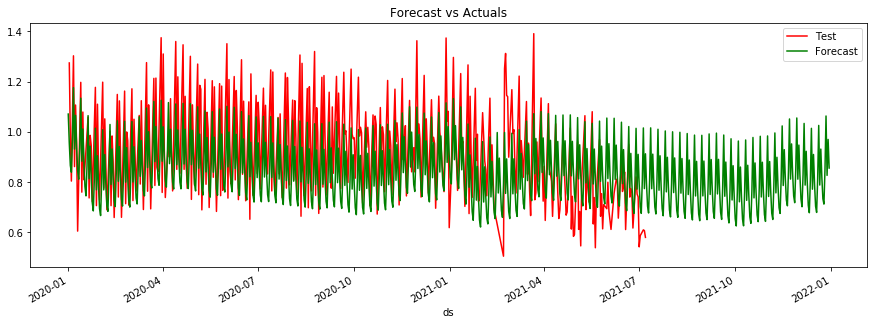

In [21]:
df_gc_test.ds = pd.to_datetime(df_gc_test.ds)
predictions = pd.DataFrame(forecast_gc[-365*2:])
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
df_gc_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
predictions.plot(kind='line', x='ds', y='yhat', color='green', label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [23]:

df_cv = cross_validation(m_gc, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 25 forecasts with cutoffs between 2007-03-04 00:00:00 and 2018-12-31 00:00:00


  0%|          | 0/25 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.015832,0.125826,0.099498,0.094198,0.075803,0.092043,0.756569
1,38 days,0.016030,0.126609,0.100077,0.094709,0.076368,0.092494,0.753682
2,39 days,0.016059,0.126724,0.100348,0.095216,0.076736,0.092900,0.753200
3,40 days,0.015990,0.126450,0.100531,0.095499,0.078152,0.093038,0.754224
4,41 days,0.016237,0.127426,0.101296,0.096547,0.078253,0.093883,0.750990


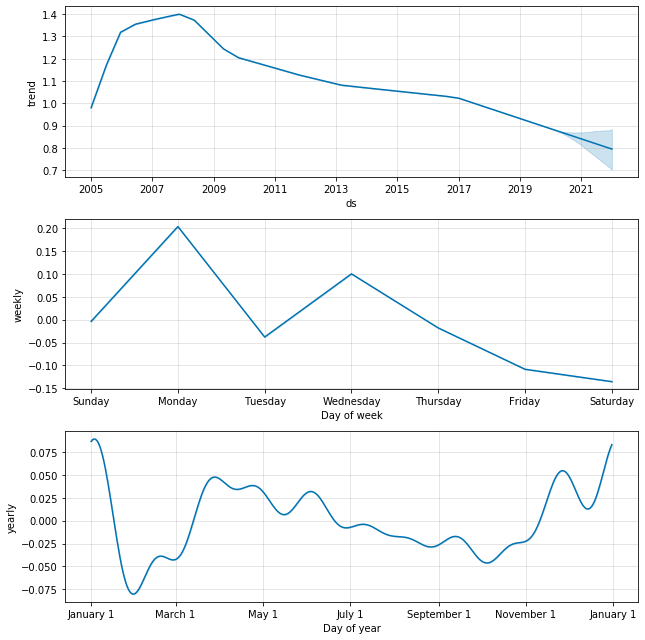

In [24]:
fig2_gc = m_gc.plot_components(forecast_gc)

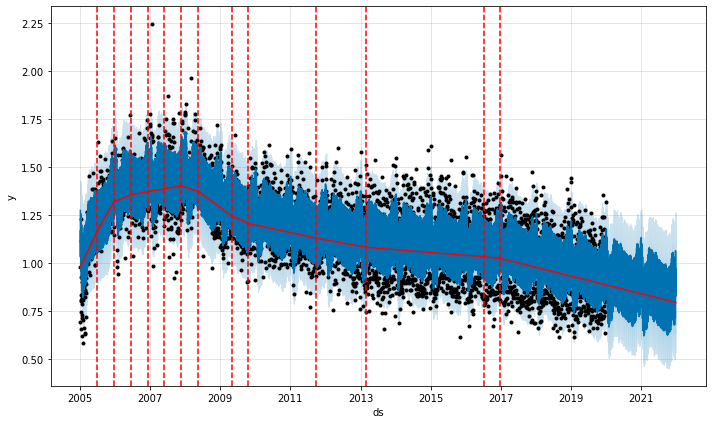

In [25]:
a = add_changepoints_to_plot(fig1_gc.gca(),m_gc,forecast_gc)
fig1_gc

#### Recycling

In [26]:
df_rec = filtered_data[filtered_data['Load.Type'] == "RECYCLING - SINGLE STREAM"].groupby('date')['waste_by_person'].sum().reset_index()
df_rec.columns = ['ds', 'y']
df_rec = df_rec[df_rec.y > 0.2]
df_rec_train = df_rec[df_rec.ds < '2019-01-01']
df_rec_test = df_rec[df_rec.ds >= '2019-01-01']


In [27]:
m_rec = Prophet()
m_rec.fit(df_rec_train);
future_rec = m_rec.make_future_dataframe(periods=365*3);

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
forecast_rec = m_rec.predict(future_rec)
forecast_rec[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail();

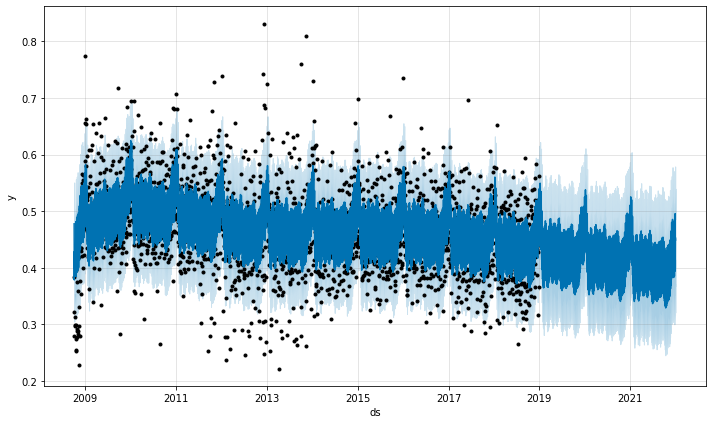

In [34]:
fig1_rec = m_rec.plot(forecast_rec)

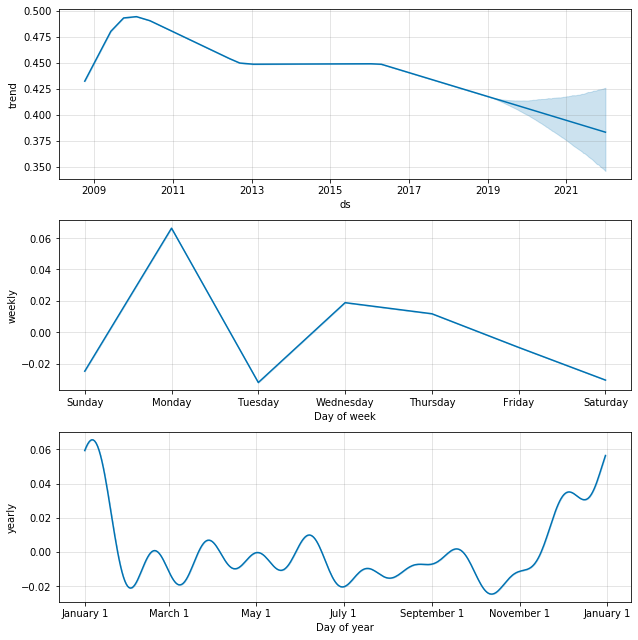

In [31]:
fig2_rec = m_rec.plot_components(forecast_rec)

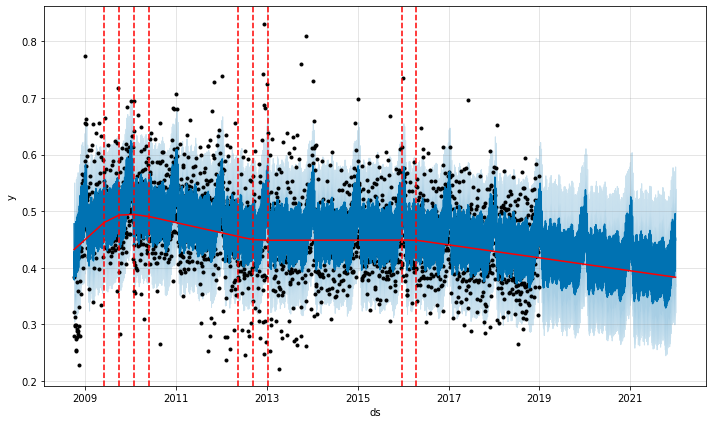

In [32]:

a = add_changepoints_to_plot(fig1_rec.gca(),m_rec,forecast_rec)
fig1_rec

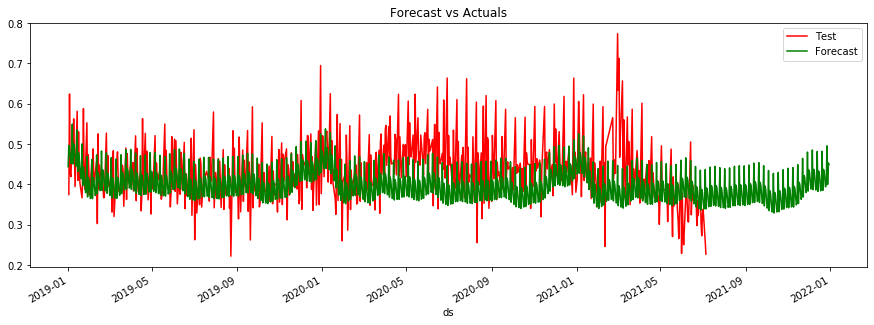

In [33]:
df_rec_test.ds = pd.to_datetime(df_rec_test.ds)
predictions = pd.DataFrame(forecast_rec[-365*3:])
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
df_rec_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
predictions.plot(kind='line', x='ds', y='yhat', color='green', label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

## 🖼️ Visualisations
Find them above

## 👓 References


## ⏭️ Appendix
Code we used to clean the data: https://github.com/darenasc/data_world_league_2022/blob/main/notebooks/claire/2022-03-06-cb-austin-data-audit.Rmd
Some data exploration and paths attempted: http://localhost:8888/tree/diego/waste_management
And more EDA and attempt with ARIMA model http://localhost:8888/tree/tom_w